In [1]:
import lstm_clv
import pandas as pd

EXPERIMENT = "cdnow"
DATAPATH = "data-cdnow"

In [2]:
# aggregate original cdnow data set to weekly base

df = pd.read_fwf(f"data-cdnow/CDNOW_master.txt")
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")

pivot = df.groupby("user").resample("W-Mon", on="date").sum()

final = pd.DataFrame({
    "user_id": pivot.index.droplevel(1),
    "ts": pivot.index.droplevel(0),
    "event": "cdnow",
    "value": pivot.reset_index(drop=True)["price"]
})
final.to_csv("data-cdnow/transactions.csv", index=False)

print(f'Time range: {final["ts"].min()} to {final["ts"].max()}')
final

Time range: 1997-01-06 00:00:00 to 1998-07-06 00:00:00


,user_id,ts,event,value
0,1,1997-01-06,cdnow,11.77
1,2,1997-01-13,cdnow,89.00
2,3,1997-01-06,cdnow,20.76
3,3,1997-01-13,cdnow,0.00
4,3,1997-01-20,cdnow,0.00
...,...,...,...,...
477738,23568,1997-04-14,cdnow,0.00
477739,23568,1997-04-21,cdnow,0.00
477740,23568,1997-04-28,cdnow,14.99
477741,23569,1997-03-31,cdnow,25.74


In [3]:
# initiate experiment and prepare data

config = lstm_clv.make_config(
    experiment_name=EXPERIMENT,
    raw_data_path=DATAPATH,
    min_nr_actions=5,
    epochs=50,
    early_stop_after_epochs=5,
    verbose=0,
)
lstm_clv.create_experiment(config)

In [4]:
_ = lstm_clv.prepare_data(EXPERIMENT)

2021-11-27 10:20:40,890 preparation [WARNING] User attributes not available, using 1 for all users.
2021-11-27 10:20:40,891 preparation [WARNING] Profit margins not available, using 1 for all events.
2021-11-27 10:20:41,623 preparation [INFO] Keeping only users with > 5 actions
2021-11-27 10:20:41,647 preparation [INFO] All data: UserEvents with 2370 users, 79 weeks, 24669 nonzero events, avg. of 10.41 per user
2021-11-27 10:20:41,649 preparation [INFO] Train: UserEvents with 2370 users, 69 weeks, 22824 nonzero events, avg. of 9.63 per user


In [5]:
# compute benchmark (Pareto/NBD + Gamma-Gamma)

benchmark = lstm_clv.evaluate_benchmark(EXPERIMENT)
benchmark.performance

2021-11-27 10:20:43,334 benchmark [INFO] Predicting values for weeks 69--79 (10 weeks) for 2370 users.
/Users/gleb/Library/Caches/pypoetry/virtualenvs/lstm-clv-ufzOi7wy-py3.9/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Model performance: 
{
    "r2": 0.4455,
    "mse": 88663.9319,
    "mae": 222.0771,
    "hit_ratio_top_50": 0.6002,
    "hit_ratio_top_25": 0.4966,
    "hit_ratio_top_10": 0.4262,
    "avg_clv_true": 34.91081,
    "avg_clv_pred": 256.2914,
    "total_true": 82738.61,
    "total_pred": 607410.6151
}

In [6]:
# find best hyperparameters for the LSTM-CLV

parameter_search = lstm_clv.ParameterGridSearch(
    experiment=EXPERIMENT,
    lstm_window=[3, 6, 12, 24],
    lstm_units=[50, 100, 150],
    learning_rate=[0.001, 0.01, 0.05],
    batch_size=[100, 500, 1000],
)
parameter_search.optimize(max_combinations=30, target="val_loss")

2021-11-27 10:21:31,529 grid_search [INFO] Computing 30 out of 108 grid combinations using 12 available CPUs.
Constructing batches:  92%|█████████▏| 2191/2370 [00:05<00:00, 645.01it/s]2021-11-27 10:21:36.931330: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-27 10:21:36.978247: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-27 10:21:38.103337: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Dee

,lstm_window,lstm_units,learning_rate,batch_size,loss
0,24,100,0.001,1000,0.3393
1,24,50,0.001,500,0.3409
2,6,100,0.001,1000,0.3202
3,6,100,0.050,1000,0.3222
4,6,150,0.050,100,0.3222
5,3,50,0.010,1000,0.3267
6,3,50,0.050,500,0.3281
7,12,100,0.010,100,0.3230
8,12,50,0.001,500,0.3235
9,6,50,0.001,1000,0.3209


2021-11-27 10:57:08.391419: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


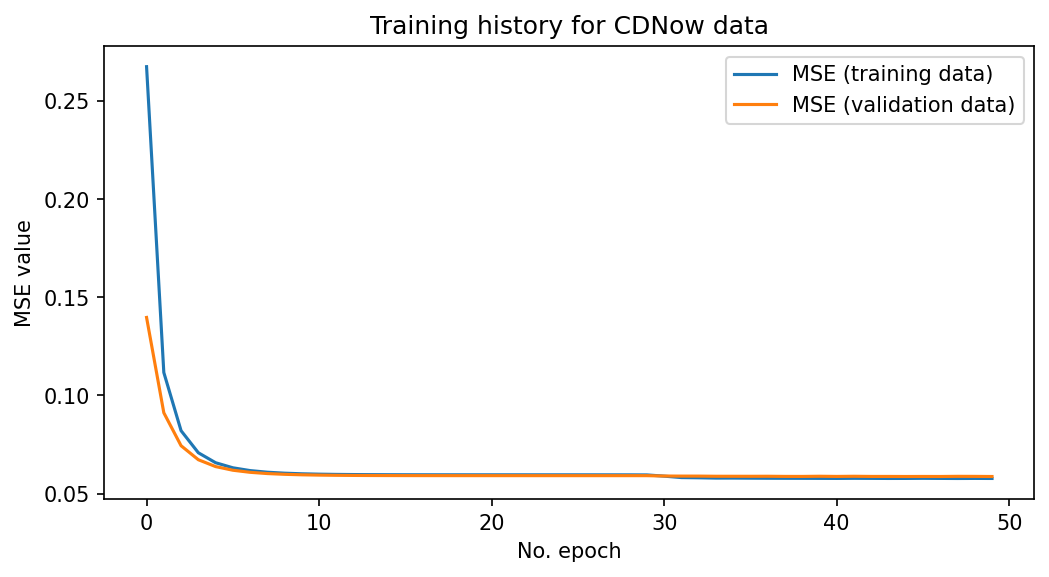

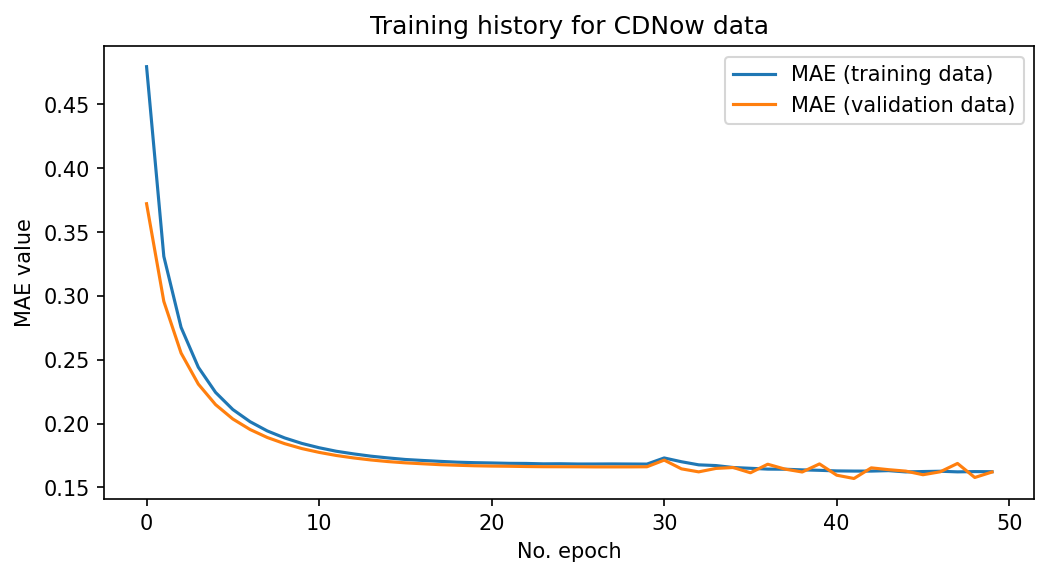

In [9]:
# re-train the model for the best combination of parameters

history = lstm_clv.train_lstm(EXPERIMENT)
lstm_clv.plot_training_history(history, "Training history for CDNow data")

In [10]:
# evaluate the model performance

results = lstm_clv.evaluate_lstm(EXPERIMENT)
results

2021-11-27 11:44:29,246 lstm-model [INFO] Predicting values for weeks 69--79


Model performance: 
{
    "r2": 0.4207,
    "mse": 7078.5126,
    "mae": 33.6469,
    "hit_ratio_top_50": 0.6295,
    "hit_ratio_top_25": 0.4695,
    "hit_ratio_top_10": 0.3924,
    "avg_clv_true": 34.91081,
    "avg_clv_pred": 4.61256,
    "total_true": 82738.61,
    "total_pred": 10931.7564
}
Distribution of true values:
       min      mean     max       std
cdnow  0.0  3.491081  814.55  5.370912
Distribution of predicted values:
            min      mean        max       std
cdnow  0.177149  0.461256  16.920848  0.081898